## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import pickle
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Make a list of calibration images
images = glob.glob(r'camera_cal\calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    
    # Read in a calibration image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If corners are found, add objects points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

In [ ]:
# Test undistortion on an image
img = mpimg.imread(r'camera_cal\calibration2.jpg')

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Undistort a test image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(r'output_images\test_undist.jpg', dst)

# Save the camera calibration result for later use
dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [ ]:
# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(r'output_images\test6_undist.jpg', dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

## Thresholding

In [2]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the output from cv2.Sobel()
    abs_sobel = np.absolute(sobel)
    
    # Scale the result to an 8-bit range (0-255)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # Apply lower and upper thresholds
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # Create grad_binary
    return grad_binary

def hls_channel_thresh(img, channel='s', thresh=(0, 255)):
    # Convert image to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Select HLS channel
    if channel == 'h':
        sel_channel = H
    if channel == 'l':
        sel_channel = L
    if channel == 's':
        sel_channel = S
    
    # Threshold selected channel
    channel_binary = np.zeros_like(sel_channel)
    channel_binary[(sel_channel >= thresh[0]) & (sel_channel <= thresh[1])] = 1
    
    # Create channel_binary
    return channel_binary

def combine_thresh(img):
    # Threshold x-axis gradient
    grad_binary = abs_sobel_thresh(img, orient='x', thresh=(20, 100))
    
    # Threshold saturation channel
    sat_binary = hls_channel_thresh(img, channel='s', thresh=(90, 255))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) | (sat_binary == 1)] = 1
    
    # Create combined binary
    return combined_binary

Text(0.5, 1.0, 'Binary Image')

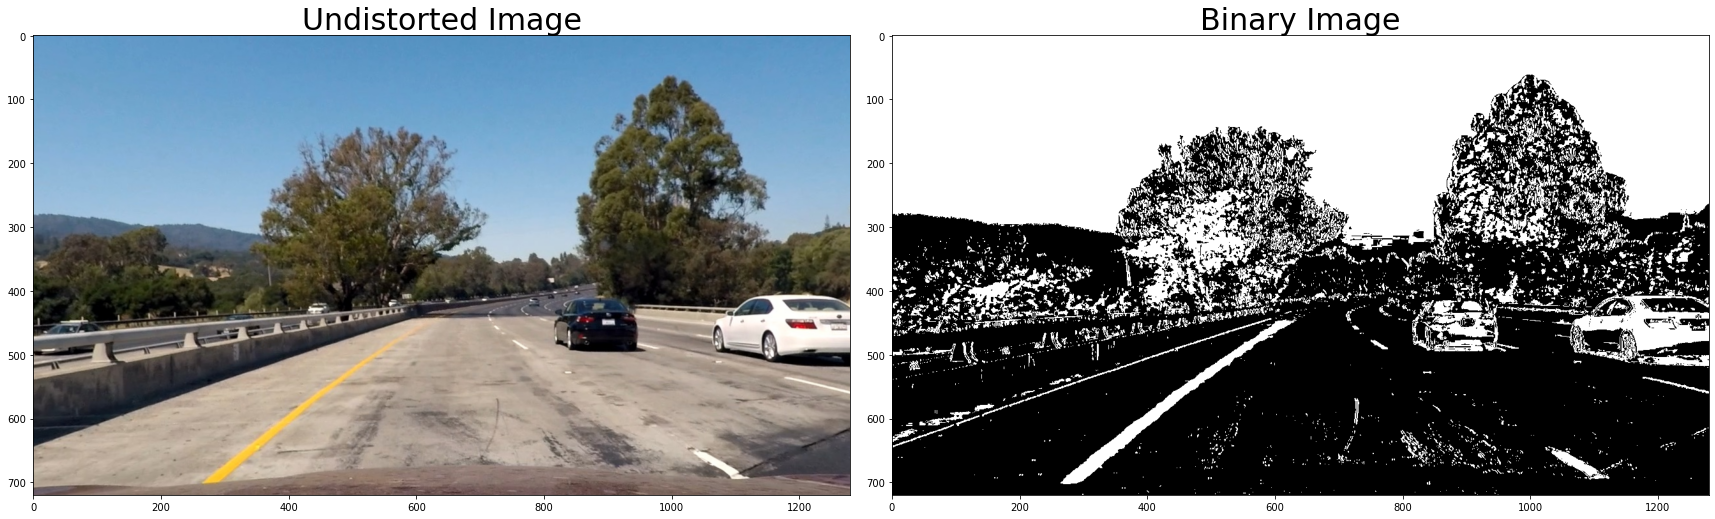

In [4]:
# Apply distortion correction to a raw image
img = mpimg.imread(r'test_images\test1.jpg')

# Read in the saved camera matrix and distortion coefficients
dist_pickle = pickle.load(open('wide_dist_pickle.p', 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']

# Undistort a raw image
dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(r'output_images\test6_undist.jpg', dst)

# Create a thresholded binary image
binary_image = combine_thresh(dst)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(dst)
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Binary Image', fontsize=30)